# Exploring Willy Wonka

### Introduction

In this lesson, let's separate out power users from non power users.

### Loading the Data

In [1]:
from lib import load_data
import pandas as pd

engine, df = load_data()
df[:2]

,order_id,user_id,list_sku,list_sku_category,list_sku_flavor,list_lineitem_id,order_date,month,week,day_of_week,...,order_coupon_code,order_referrer,order_ad_shown,order_store_city,order_store_id,order_day_part,order_is_freeshipping,user_loyalty_program,user_age,user_gender
0,TXN-52889719,USER-16961214,SKU-3002,Energy Bar,Peanut Butter,ITEM-2009089674,2021-05-04,5.0,18.0,2.0,...,express5,Microsoft,week40_10,Dallas,Dallas-3,evening,1,bronze,49,F


### Percentile Spend by user

Write a sql query to calculate a running total of the total spend per user.  For example, maybe the top spending user is responsible for .016% of of all sales.  And by the second user we get to .03% spend of all sales, as that second user is responsible for .14% of all sales.

> Write the query below.

In [3]:
query = """with  user_spend as (
    select user_id, sum(order_value) as total_order_value 
    from raw_lineitems 
    group by user_id
    order by total_order_value desc),
    user_running_total as (
    select user_id, total_order_value,
    sum(total_order_value) over (order by total_order_value desc) as running_total,
    sum(total_order_value) over () as total_spend
    from user_spend)
    select user_id, total_order_value, running_total/total_spend as percentage_spend from user_running_total;
"""
user_percentage_spend = pd.read_sql(query, engine)

user_percentage_spend[:4]

# 	user_id	total_order_value	percentage_spend
# 0	USER-17215538	972.923950	0.000160
# 1	USER-17070511	861.416265	0.000302
# 2	USER-17014986	748.281205	0.000425
# 3	USER-17115875	733.177872	0.000546

,user_id,total_order_value,percentage_spend
0,USER-17215538,972.923950,0.000160
1,USER-17070511,861.416265,0.000302
2,USER-17014986,748.281205,0.000425
3,USER-17115875,733.177872,0.000546


Find the percentage of users who account for power users and the percentage that account for non power users.  Power users are the collection of users who account for the top 50% of revenue.  We should see that 17.28% of users account for 50 percent of revenue.

* Power users

In [5]:
power_users = user_percentage_spend[user_percentage_spend['percentage_spend'] < .50]
power_users.shape

(17777, 3)

* Core users

In [6]:
core_users = user_percentage_spend[user_percentage_spend['percentage_spend'] > .50]

core_users.shape

(85073, 3)

In [7]:
power_users.shape[0]/user_percentage_spend.shape[0]

0.1728439474963539

### Now select the power users

Then select the lineitems of the powerusers and those of the nonpower_users save them to two different tables -- `poweruser_lineitems` and `nonpower_lineitems`.  When calling `to_sql`, you may have to set `index = False` so that the index does not get stored to the table.

In [10]:
query = """select * from raw_lineitems"""
line_items_df = pd.read_sql(query, engine)

In [11]:
line_items_df.index = line_items_df.user_id

In [12]:
power_user_line_items_df = line_items_df.loc[line_items_df.user_id]

In [25]:
non_power_user_lineitems_df = line_items_df.loc[core_users.user_id]
non_power_user_lineitems_df[:2]

,order_id,user_id,list_sku,list_sku_category,list_sku_flavor,list_lineitem_id,order_date,month,week,day_of_week,...,order_coupon_code,order_referrer,order_ad_shown,order_store_city,order_store_id,order_day_part,order_is_freeshipping,user_loyalty_program,user_age,user_gender
user_id,,,,,,,,,,,,,,,,,,,,,
USER-17065335,TXN-53039655,USER-17065335,SKU-5011,Protein Bar,Chocolate Brownie,ITEM-2008923919,2021-04-29,4.0,17.0,4.0,...,merrychocolate,Google,week38_20,New York,NewYork-1,evening,0,bronze,32,F
USER-17203701,TXN-53064141,USER-17203701,SKU-3000,Energy Bar,Cherry Vanilla,ITEM-2009034278,2021-03-14,3.0,10.0,0.0,...,express5,Microsoft,week25_ 2,Detroit,Detroit-3,evening,1,silver,33,M


In [27]:
non_power_user_lineitems_df.to_sql('nonpower_lineitems', engine, index = False, if_exists='replace')

613

In [28]:
power_user_line_items_df = line_items_df.loc[power_users.user_id]
power_user_line_items_df.to_sql('poweruser_lineitems', engine, if_exists='replace', index = False)

414

### Now compare power users to core users

Use the group_and_print function to quickly do so.  See if there are any differences between the two groups.  

> Unfortunately, there are not too many differences.

Finally write down any insights below.

* Summary - The data does not reveal much difference between our power users (who account for 80% of )and the normal users.  
* More research needed on the power users -- what keeps them returning?  What other similar competitors do they shop at, and can we offer more similar products.
* There is a small difference in product preference, with users spending on healthy food like energy shots, and protein..whereas non-power users spend more on granola bars.
* Odd that the marketing emphasizes things like chocolate whereas users appear to be more health conscious.
* Top loyalty program is silver followed by none -- so appears that gold and bronze are underperforming.


list_sku


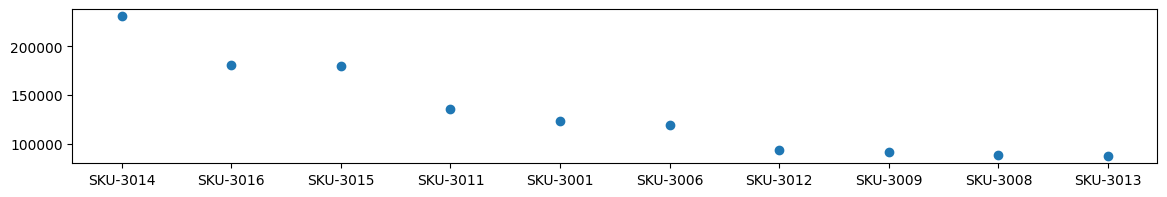

list_sku_category


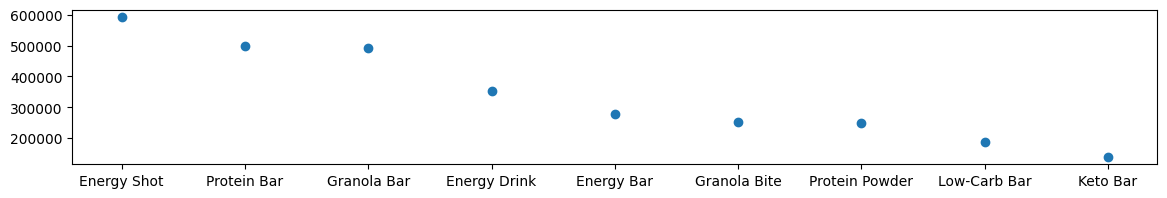

list_sku_flavor


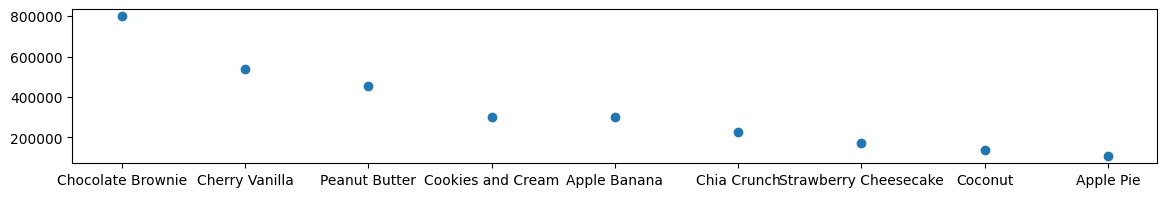

In [34]:
from lib import group_and_print
group_and_print('poweruser_lineitems', product_cols, engine)

order_channel


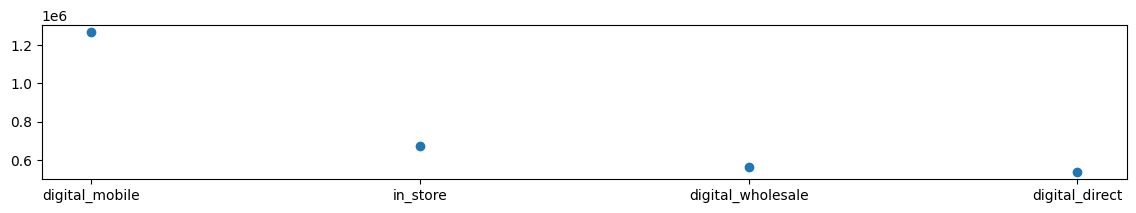

order_referrer


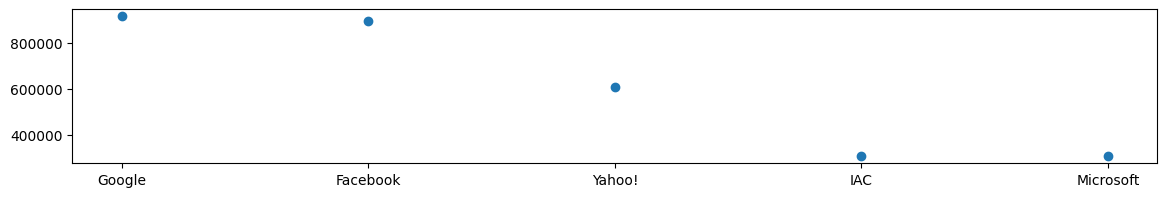

order_ad_shown


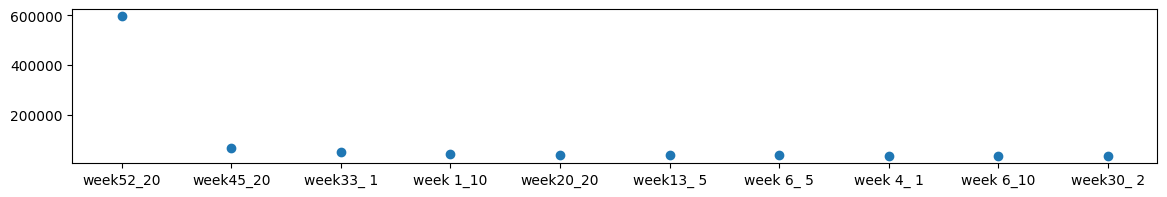

order_is_freeshipping


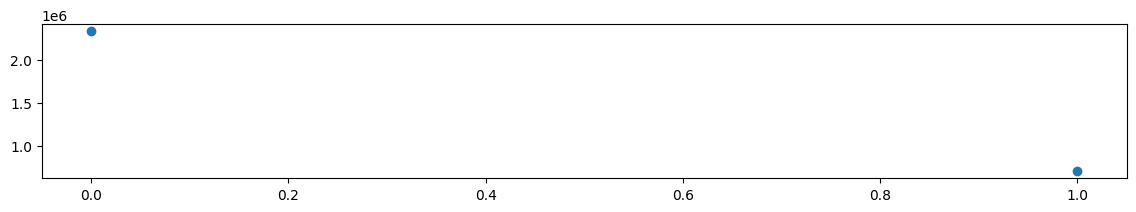

order_coupon_code


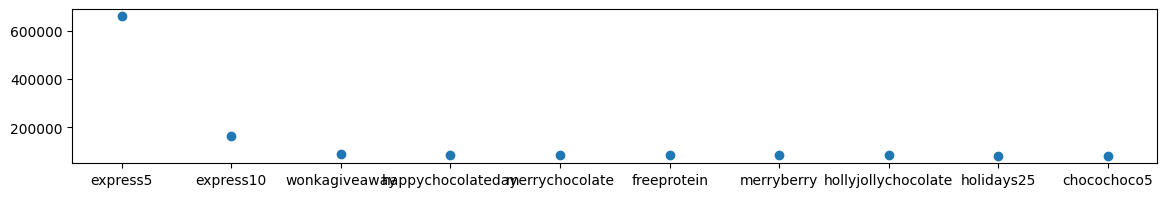

user_loyalty_program


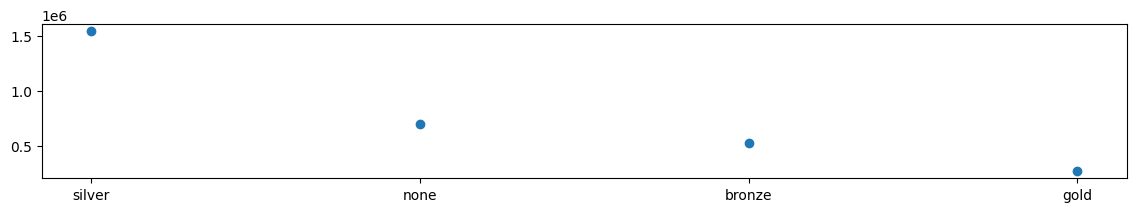

In [32]:
group_and_print('poweruser_lineitems', marketing_cols, engine)